**File name**: evaluation_roms.ipynb

**Author**:  Ueslei Adriano Sutil

**Email**: [ueslei@putlook.com](mailto:ueslei@putlook.com)

**Created**: 01 September 2020

**Last modified**: 02 September 2020

**Version**: 1.5

**Python**: 3.7.9
- - -
<br>


** 1. Evaluate ROMS output using:**

- Bias (Contour);
<br>
$
\begin{equation}
BIAS = A_{t}-F_{t}
\end{equation}
$

- Root Mean Square Error (RMSE; Contour);
<br>
$
\begin{equation}
RMSE = \sqrt{\sum_{i=1}^{n}\frac{(A_{t}-F_{t})^2}{n}}
\end{equation}
$

- Mean Absolute Percentage Error (MAPE; Contour);
<br>
$
\begin{equation}
MAPE = \frac{1}{n}\sum_{t=1}^{n}\left | \frac{A_{t}-F_{t}}{A_{t}} \right |
\end{equation}
$
<br>

Where $A_{t}$ is the actual value, $F_{t}$ is the forecast value and $n$ is the number of observations.
<br>

** 2. Compare ROMS output with:**
- GLORYS12V1 (Fernandez & Lellouch, 2018; [[Access here]](http://marine.copernicus.eu/services-portfolio/access-to-products/?option=com_csw&view=details&product_id=GLOBAL_REANALYSIS_PHY_001_030)):)
    - Sea Surface Temperature (°C);
    - Current Speed at surface (m.s⁻¹).

- OSCAR (Bonjean & Lagerloef et al., 2002; [[Access here]](https://podaac.jpl.nasa.gov/dataset/OSCAR_L4_OC_third-deg)):
    - Ocean Current Speed at surface (m.s⁻¹);


** 3. Disclaimers: **
- Both Observed and Simulated variables needs to match the same time-step. 
- ROMS has a better spatial resolution than both database.
- Post-process ROMS outputs to match with the databases:<br>
  
    - MUR and GLORYS (Daily data):<br>
            `ncks -v temp,u,v -d s_rho,29,29 roms_his.nc roms_evaluation.nc`<br>
            `cdo daymean roms_evaluation.nc roms_evaluation_mean.nc`<br>
            `cdo splitday roms_evaluation_mean.nc roms_evaluation_mean`<br>
            `cdo cat roms_evaluation_mean01 roms_evaluation_mean02 ... roms_ts_daymean.nc`<br>
   
    - OSCAR (Each 5 days data):<br>
            `ncks -v u,v -d s_rho,49,49 roms_avg.nc roms_evaluation.nc`<br>
            `cdo daymean roms_evaluation.nc roms_evaluation_mean.nc`<br>
            `cdo splitday roms_evaluation_mean.nc roms_evaluation_mean`<br>
            `cdo cat roms_evaluation_mean21 roms_evaluation_mean26 roms_evaluation_final.nc`

- - -

** 1. Import libraries. **

In [1]:
import netCDF4
import pyresample
import cmocean
import os
from   mpl_toolkits.basemap import Basemap
from   wrf                  import getvar,extract_times
from   roms_libs            import *
from   tqdm                 import tqdm
from   time                 import sleep
import numpy                as np
import matplotlib.pyplot    as plt
import pickle

#### 2. Choose which datase, variable and metric will be used to compare with WRF output.

In [2]:
print('Evaluate Sea Surface Temperature using: (1) Glorys or (2) OSCAR.') 
dataset  = input()
if dataset == '1':
    print('Evaluate which ROMS variable? (1) Sea Surface Temperature or (2) Current Speed at Surface.')
    contourf_var = input()
elif dataset == '2':
    contourf_var = '2' 
print('Which statistical metric? (1) Root Mean Square Error, (2) Mean Absolute Error or (3) Bias.')
metric  = input()

Evaluate Sea Surface Temperature using: (1) Glorys or (2) OSCAR.
Evaluate which ROMS variable? (1) Sea Surface Temperature or (2) Current Speed at Surface.
Which statistical metric? (1) Root Mean Square Error, (2) Mean Absolute Error or (3) Bias.


** 3. Set customizations. **

In [3]:
# Set map boundaries.
bbox            = [-53,-43,-33,-23]
lonbounds       = [-53,-43] 
latbounds       = [-33,-23]

# Set files path.
roms_dir       = '/media/ueslei/Ueslei_HD/INPE/PCI/Projetos/SC_2008/Outputs/normal/roms_ts_daymean.nc'
roms_oscar_dir = '/media/ueslei/Ueslei_HD/INPE/PCI/Projetos/SC_2008/Outputs/normal/roms_oscar_eval.nc'
mur_dir        = '/media/ueslei/Ueslei_HD/INPE/PCI/Projetos/SC_2008/Dados/Evaluation/MUR/mur.nc' 
glorys_dir     = '/media/ueslei/Ueslei_HD/INPE/PCI/Projetos/SC_2008/Dados/Evaluation/Glorys/glorys.nc'  
oscar_dir      = '/media/ueslei/Ueslei_HD/INPE/PCI/Projetos/SC_2008/Dados/Evaluation/OSCAR/oscar.nc' 

# Set range.
clevs_rmse = np.arange(0,5.05,0.01)
ticks_rmse = np.arange(min(clevs_rmse),max(clevs_rmse),1)
clevs_mape = np.arange(0,18.02,0.01)
ticks_mape = np.arange(min(clevs_mape),max(clevs_mape),2)
clevs_bias = np.arange(-1,1.1,0.01)
ticks_bias = np.arange(min(clevs_bias),max(clevs_bias),0.5)

#### 4. Collect data from the observed data.

In [4]:
# Open files and load lat/lon coords.
if dataset == '1':
    glorys_file = '/media/ueslei/Ueslei_HD/INPE/PCI/Projetos/SC_2008/Dados/Evaluation/Glorys/glorys.nc' 
    nc_obs    = netCDF4.Dataset(glorys_file)
    lon_obs   = nc_obs.variables['longitude'][:]
    lat_obs   = nc_obs.variables['latitude'][:]
elif dataset == '2':
    oscar_file = '/media/ueslei/Ueslei_HD/INPE/PCI/Projetos/SC_2008/Dados/Evaluation/OSCAR/oscar.nc' 
    nc_obs    = netCDF4.Dataset(oscar_file)
    lon_obs   = nc_obs.variables['longitude'][:]-360
    lat_obs   = nc_obs.variables['latitude'][:]   

# Calculate lat/lon coords based on the bounds chosen in step 2.
latli = np.argmin(np.abs(lat_obs-latbounds[1]))
latui = np.argmin(np.abs(lat_obs-latbounds[0])) 
lonli = np.argmin(np.abs(lon_obs-lonbounds[0]))
lonui = np.argmin(np.abs(lon_obs-lonbounds[1])) 

# Reopen lat/lon coords with the exactly gridpoin based on the chosen bounds.
if dataset == '1':
    lon_obs = nc_obs.variables['longitude'][lonli:lonui]
    lat_obs = nc_obs.variables['latitude'][latui:latli]
elif dataset == '2':
    lon_obs = nc_obs.variables['longitude'][lonli:lonui]-360
    lat_obs = nc_obs.variables['latitude'][latli:latui]

#lat_obs1 = lat_obs.data
#lat_obs1.tofile('observed_oscar_lat.csv', sep=',', format='%s')
#raise SystemError(0)   

# Lon/lat.
lon_obs,lat_obs = np.meshgrid(lon_obs,lat_obs)
lat_obs_len = len(lat_obs[:,0])
lon_obs_len = len(lon_obs[0, :])
lat_obs_len = len(lat_obs[:])
lon_obs_len = len(lon_obs[:])

# Count how many time steps in file.
#loop = len(nc_obs.variables['time'][:]) 
loop = 1

# Create variable to store data.
if dataset == '1' and contourf_var == '1':
    var = np.zeros([loop,lat_obs_len,lon_obs_len])
    observed = np.zeros([loop,lat_obs_len,lon_obs_len])
elif dataset == '1' and contourf_var == '2':
    var1 = np.zeros([loop,lat_obs_len,lon_obs_len])
    var2 = np.zeros([loop,lat_obs_len,lon_obs_len])
    observed1 = np.zeros([loop,lat_obs_len,lon_obs_len])
    observed2 = np.zeros([loop,lat_obs_len,lon_obs_len])   
elif dataset == '2':
    var1 = np.zeros([loop,lat_obs_len,lon_obs_len])
    var2 = np.zeros([loop,lat_obs_len,lon_obs_len])
    observed1 = np.zeros([loop,lat_obs_len,lon_obs_len])
    observed2 = np.zeros([loop,lat_obs_len,lon_obs_len])

# Do the loop though the time steps and store data in a new observed variable.
with tqdm(total=loop) as pbar:
        for i in range(0,loop):
            if dataset == '1' and contourf_var == '1':
                var = nc_obs.variables['thetao'][i,0,latui:latli,lonli:lonui]
                var = var.astype(np.float)
                observed[i,:,:] = var 
                #np.savetxt('observed_glorys_temp.csv', var[:,:], delimiter=',')
            elif dataset == '1' and contourf_var=='2':
                var1 = nc_obs.variables['uo'][i,0,latui:latli,lonli:lonui]
                var2 = nc_obs.variables['vo'][i,0,latui:latli,lonli:lonui]
                var1 = var1.astype(np.float)
                var2 = var2.astype(np.float)
                observed1[i,:,:] = var1
                observed2[i,:,:] = var2    
            elif dataset == '2':
                var1 = nc_obs.variables['u'][i,0,latli:latui,lonli:lonui]
                var2 = nc_obs.variables['v'][i,0,latli:latui,lonli:lonui]
                var1 = var1.astype(np.float)
                var2 = var2.astype(np.float)
                observed1[i,:,:] = var1
                observed2[i,:,:] = var2 
            sleep(0.1)
            pbar.update(1)
if dataset == '1' and contourf_var== '2':
    observed = np.sqrt(observed1**2 + observed2**2) 
if dataset == '2':
    observed = np.sqrt(observed1**2 + observed2**2)                         

100%|██████████| 1/1 [00:00&lt;00:00,  9.59it/s]


#### 4. Collect data from the resampled simulated data.

In [6]:
# Open files and load lat/lon coords.
nc_sim  = netCDF4.Dataset(roms_dir)
lon_rho = nc_sim.variables['lon_rho'][:,:]
lat_rho = nc_sim.variables['lat_rho'][:,:]

# Calculate lat/lon coords based on the bounds chosen in step 2.
i0,i1,j0,j1  = bbox2ij(lon_rho,lat_rho,bbox)
lon_sim     = lon_rho[j0:j1, i0:i1]
lat_sim     = lat_rho[j0:j1, i0:i1]
 
# Lon/lat length.
lat_sim_len = len(lat_rho[j0:j1,0])
lon_sim_len = len(lon_rho[0, i0:i1])


# Create variable to store data.
# Since MUR has a higher spatial resolution than ROMS output, change the expected variable.
if dataset == '1' and contourf_var == '1':
    var = np.zeros([loop,lat_sim_len,lon_sim_len])
    expected = np.zeros([loop,lat_obs_len,lon_obs_len])
if dataset == '1' and contourf_var == '2':
    var1 = np.zeros([loop,lat_sim_len,lon_sim_len])
    var2 = np.zeros([loop,lat_sim_len,lon_sim_len])
    expected1 = np.zeros([loop,lat_obs_len,lon_obs_len])    
    expected2 = np.zeros([loop,lat_obs_len,lon_obs_len])    
if dataset == '2':
    var1 = np.zeros([loop,lat_sim_len,lon_sim_len])
    var2 = np.zeros([loop,lat_sim_len,lon_sim_len])
    expected1 = np.zeros([loop,lat_obs_len,lon_obs_len])    
    expected2 = np.zeros([loop,lat_obs_len,lon_obs_len])  

# First step to resample simulate data.
orig = pyresample.geometry.SwathDefinition(lons=lon_sim, lats=lat_sim)
targ = pyresample.geometry.SwathDefinition(lons=lon_obs, lats=lat_obs)

# Do the loop though the time steps and store data in a new observed variable.
with tqdm(total=loop) as pbar:
    for i in range(0,loop):
        if dataset == '1' and contourf_var == '1':
            var[:,:,:]         = nc_sim.variables['temp'][i,0,j0:j1, i0:i1]
        elif dataset == '1' and contourf_var == '2':
            var1[:,:,:]   = nc_sim.variables['u'][i,0,j0:j1, i0:i1]
            var2[:,:,:]   = nc_sim.variables['v'][i,0,j0:j1, i0:i1] 
        elif dataset == '2':
            var1[:,:,:] = nc_sim.variables['u'][i,0,j0:j1, i0:i1]  
            var2[:,:,:]   = nc_sim.variables['v'][i,0,j0:j1, i0:i1]         
        sleep(0.1)
        pbar.update(1)

# Second loop to resample with the stored variable.
with tqdm(total=loop) as pbar:
    for i in range(0,loop,1):
        if dataset == '1' and contourf_var=='1':          
            expected[i,:,:] = pyresample.kd_tree.resample_gauss(orig, var[i,:,:], targ,radius_of_influence=50000, sigmas=25000, fill_value=None)
        if dataset == '1' and contourf_var=='2':           
            expected1[i,:,:] = pyresample.kd_tree.resample_gauss(orig, var1[i,:,:], targ,radius_of_influence=50000, sigmas=25000, fill_value=None)            
            expected2[i,:,:] = pyresample.kd_tree.resample_gauss(orig, var2[i,:,:], targ,radius_of_influence=50000, sigmas=25000, fill_value=None)    
        if dataset == '2':              
            expected1[i,:,:] = pyresample.kd_tree.resample_gauss(orig, var1[i,:,:], targ,radius_of_influence=50000, sigmas=25000, fill_value=None)            
            expected2[i,:,:] = pyresample.kd_tree.resample_gauss(orig, var2[i,:,:], targ,radius_of_influence=50000, sigmas=25000, fill_value=None)               
        sleep(0.1)
        pbar.update(1)
#np.savetxt('expected_roms_temp.csv', expected[0,:,:], delimiter=',')

if dataset == '1' and contourf_var=='2':                  
    expected = np.sqrt(expected1**2 + expected2**2) 
elif dataset == '2':
    expected = np.sqrt(expected1**2 + expected2**2) 

100%|██████████| 1/1 [00:00&lt;00:00,  6.25it/s]


** 5. Calculate the metrics. **

In [187]:
# Calculate Root Mean Square Error.
if metric == '1':
    differences         = expected-observed
    differences_squared = differences ** 2 
    mean_of_differences_squared = np.average(differences_squared,axis=0)
    val                 = np.sqrt(mean_of_differences_squared)

# Calculate Mean Absolute Error.
elif metric == '2':
    val = np.abs((observed-expected)/observed).mean(axis=0)*100

# Calculate Bias.
elif metric == '3':
    expected1 = np.average(expected,axis=0) 
    observed1 = np.average(observed,axis=0)
    val       = expected1-observed1

# If ROMS is coupled with WRF, the mask near the coawst may create dummy value. Nan then.
val[val > 30000] = np.nan

** 6. Create and plot map and then save. **

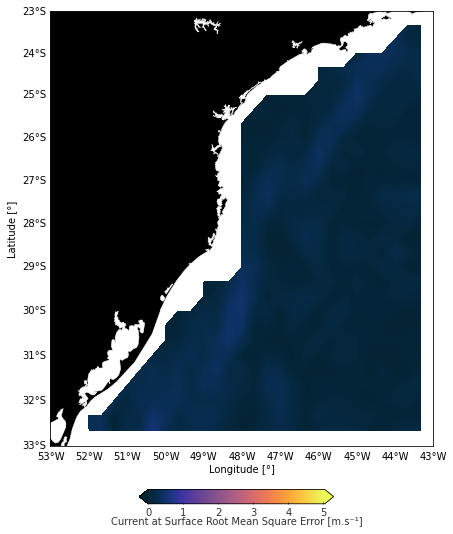

In [188]:
# Create and plot map.
m    = Basemap(projection='merc',llcrnrlat=bbox[2],urcrnrlat=bbox[3],llcrnrlon=bbox[0],urcrnrlon=bbox[1], lat_ts=30,resolution='i')
fig  = plt.figure(1,figsize=(10,8))
plt.xlabel('Longitude'u' [\N{DEGREE SIGN}]',labelpad=18,size=10)
plt.ylabel('Latitude'u' [\N{DEGREE SIGN}]',labelpad=33,size=10)
ax   = fig.add_subplot(111)
m.drawparallels(np.arange(-90.,120.,1.), linewidth=0.00, color='black', labels=[1,0,0,1],labelstyle="N/S",fontsize=10)
m.drawmeridians(np.arange(-180.,180.,1.), linewidth=0.00,color='black', labels=[1,0,0,1],labelstyle="N/S",fontsize=10)
m.drawcountries(color = '#ffffff',linewidth=0.5)
m.drawcoastlines(color = '#ffffff',linewidth=0.5)
m.fillcontinents(color = '#000000')

# Map ticks and gradient.
if metric == '1':
    clevs = clevs_rmse
    ticks = ticks_rmse
    cmap  = cmocean.cm.thermal
elif metric == '2':
    clevs = clevs_mape
    ticks = ticks_mape
    cmap  = cmocean.cm.thermal
elif metric == '3':
    clevs = clevs_bias
    ticks = ticks_bias
    cmap  = cmocean.cm.balance

# Map pallete and plot
if metric == '1' or metric == '2':
    h1    = m.contourf(lon_obs, lat_obs, val, clevs,latlon=True,cmap=cmap,extend="both") 
elif metric == '3':
    h1    = m.contourf(lon_obs, lat_obs, val, clevs,latlon=True,cmap=cmap,norm=MidpointNormalize(midpoint=0),extend="both")   
cax   = fig.add_axes([0.37, 0.025, 0.27, 0.025])     
cb    = fig.colorbar(h1, cax=cax, orientation="horizontal",panchor=(0.5,0.5),shrink=0.3,ticks=ticks)

# Map legend.
if contourf_var == '1' and metric =='1':
    cb.set_label(r'Sea Surface Temperature Root Mean Square Error [$^\circ\!$C]', fontsize=10, color='0.2',labelpad=-0.5)
elif contourf_var == '1' and metric =='2':
    cb.set_label(r'Sea Surface Temperature Mean Absolute Percentage Error [%]', fontsize=10, color='0.2',labelpad=-0.5)
elif contourf_var == '1' and metric =='3':
    cb.set_label(r'Sea Surface Temperature Bias [$^\circ\!$C]', fontsize=10, color='0.2',labelpad=-0.5)
elif contourf_var == '2' and metric =='1':
    cb.set_label(r'Current at Surface Root Mean Square Error [m.s⁻¹]', fontsize=10, color='0.2',labelpad=-0.5)
elif contourf_var == '2' and metric =='2':
    cb.set_label(r'Current at Surface Mean Absolute Percentage Error [m.s⁻¹]', fontsize=10, color='0.2',labelpad=-0.5)
elif contourf_var == '2' and metric =='3':
    cb.set_label(r'Current at Surface Bias [m.s⁻¹]', fontsize=10, color='0.2',labelpad=-0.5)
cb.ax.tick_params(labelsize=10, length=2, color='0.2', labelcolor='0.2',direction='in') 
cb.set_ticks(ticks)

# Create folder to store figures
try:
    os.makedirs("roms_evaluation")
except FileExistsError:
    pass 

# Save figures.
if dataset =='1' and metric =='1' and contourf_var == '1':
    plt.savefig('./roms_evaluation/sst_rmse_roms_glorys.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)   
elif dataset =='1' and metric =='2' and contourf_var == '1':
    plt.savefig('./roms_evaluation/sst_mape_roms_glorys.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)   
elif dataset =='1' and metric =='3' and contourf_var == '1':
    plt.savefig('./roms_evaluation/sst_bias_roms_glorys.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)   
elif dataset =='1' and metric =='1' and contourf_var == '2':
    plt.savefig('./roms_evaluation/sc_rmse_roms_glorys.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)   
elif dataset =='1' and metric =='2' and contourf_var == '2':
    plt.savefig('./roms_evaluation/sc_mape_roms_glorys.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)   
elif dataset =='1' and metric =='3' and contourf_var == '2':
    plt.savefig('./roms_evaluation/sc_bias_roms_glorys.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)   
elif dataset =='2' and metric=='1' and contourf_var == '1':
    plt.savefig('./roms_evaluation/sst_rmse_roms_oscar.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)   
elif dataset =='2' and metric =='2' and contourf_var == '1':
    plt.savefig('./roms_evaluation/sst_mape_roms_oscar.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)   
elif dataset =='2' and metric =='3' and contourf_var == '1':
    plt.savefig('./roms_evaluation/sst_bias_roms_oscar.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)   
